In [2]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('basics').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/05 05:37:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/05 05:37:03 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
df2 = spark.read.csv('dataset4/part-00000-e8fbff2b-4af5-4659-8ee9-feb16b3e44b4-c000.csv', header=True)
df2.describe().show()

+-------+-----------+------+------------------+-------------------+--------------------+
|summary|FECHA HECHO|GENERO|          CANTIDAD|    FECHA HECHO_STR|         Weapon Used|
+-------+-----------+------+------------------+-------------------+--------------------+
|  count|     466679|466679|            466679|             466679|              466679|
|   mean|       null|  null|1.5416313997415783|               null|                null|
| stddev|       null|  null|1.6656822733680472|               null|                null|
|    min| 2015-01-01|     F|                 1|2015-01-01 00:00:00|No Weapon or Subs...|
|    max| 2023-02-28|     M|                 9|2023-02-28 00:00:00|Using weapons and...|
+-------+-----------+------+------------------+-------------------+--------------------+



In [16]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col

df2 = df2.withColumn("CANTIDAD", col("CANTIDAD").cast(IntegerType()))
data=df2

gender_indexer = StringIndexer(inputCol="GENERO", outputCol="GENEROIndex")
gender_encoder = OneHotEncoder(inputCol="GENEROIndex", outputCol="GENEROVec")
wp_indexer = StringIndexer(inputCol="Weapon Used", outputCol="WeaponUsedIndex")
wp_encoder = OneHotEncoder(inputCol="WeaponUsedIndex", outputCol="WeaponUsedVec")

preprocessing_stages = [gender_indexer, gender_encoder, wp_indexer, wp_encoder]
preprocessing_pipeline = Pipeline(stages=preprocessing_stages)

preprocessing_model = preprocessing_pipeline.fit(data)
preprocessed_data = preprocessing_model.transform(data)

feature_cols = ["GENEROVec", "CANTIDAD", "WeaponUsedVec"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_data = assembler.transform(preprocessed_data)


# create K-Means model
kmeans = KMeans(k=4, seed=27, featuresCol="features", predictionCol="cluster")
kmeans_model = kmeans.fit(assembled_data)
clustered_data = kmeans_model.transform(assembled_data)

#silhouette_score
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator(predictionCol="cluster", featuresCol="features")
silhouette_score = evaluator.evaluate(clustered_data)
print("Silhouette Score:", silhouette_score)
clustered_data.show()

Silhouette Score: 0.6211448467015696
+-----------+------+--------+-------------------+--------------------+-----------+-------------+---------------+-------------+-----------------+-------+
|FECHA HECHO|GENERO|CANTIDAD|    FECHA HECHO_STR|         Weapon Used|GENEROIndex|    GENEROVec|WeaponUsedIndex|WeaponUsedVec|         features|cluster|
+-----------+------+--------+-------------------+--------------------+-----------+-------------+---------------+-------------+-----------------+-------+
| 2015-01-01|     F|       2|2015-01-01 00:00:00|Using weapons and...|        0.0|(1,[0],[1.0])|            0.0|(2,[0],[1.0])|[1.0,2.0,1.0,0.0]|      1|
| 2015-01-01|     M|       1|2015-01-01 00:00:00|Using weapons and...|        1.0|    (1,[],[])|            0.0|(2,[0],[1.0])|[0.0,1.0,1.0,0.0]|      1|
| 2015-01-01|     F|       1|2015-01-01 00:00:00|Using weapons and...|        0.0|(1,[0],[1.0])|            0.0|(2,[0],[1.0])|[1.0,1.0,1.0,0.0]|      1|
| 2015-01-01|     M|       1|2015-01-01 00:00

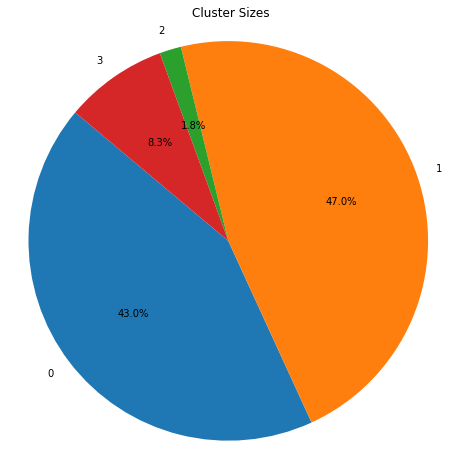

In [17]:
import matplotlib.pyplot as plt

cluster_sizes = clustered_data.groupBy("cluster").count().orderBy("cluster")


cluster_labels = cluster_sizes.select("cluster").rdd.flatMap(lambda x: x).collect()
cluster_counts = cluster_sizes.select("count").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(8, 8))
plt.pie(cluster_counts, labels=cluster_labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Cluster Sizes")
plt.show()


In [36]:
cluster_counts = clustered_data.groupBy("cluster").count()
cluster_counts.show()

+-------+------+
|cluster| count|
+-------+------+
|      1|219210|
|      3| 38849|
|      2|  8167|
|      0|200453|
+-------+------+



In [5]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

cluster_gen_count = clustered_data.groupBy("cluster", "GENERO", "CANTIDAD", "Weapon Used").count()
cluster_total = cluster_gen_count.groupBy("cluster").agg(F.sum("count").alias("total_count"))
window_spec = Window.partitionBy("cluster")

cluster_gen_percent = cluster_gen_count.withColumn("gen_percent", (F.col("count") / F.sum("count").over(window_spec)) * 100)
cluster_cantidad_percent = cluster_gen_count.withColumn("cantidad_percent", (F.col("count") / F.sum("count").over(window_spec)) * 100)
cluster_weapon_used_percent = cluster_gen_count.withColumn("weapon_used_percent", (F.col("count") / F.sum("count").over(window_spec)) * 100)

cluster_gen_percent.show()



+-------+------+--------+--------------------+------+-------------------+
|cluster|GENERO|CANTIDAD|         Weapon Used| count|        gen_percent|
+-------+------+--------+--------------------+------+-------------------+
|      0|     M|       2|No Weapon or Subs...|  4762| 2.3756192224611254|
|      0|     F|       2|No Weapon or Subs...| 15089|  7.527450325013843|
|      0|     F|       1|No Weapon or Subs...| 87823|  43.81226521927834|
|      0|     F|       1|             Unknown| 42541|  21.22243119334707|
|      0|     F|       2|             Unknown|  4252| 2.1211954922101444|
|      0|     M|       1|No Weapon or Subs...| 30335| 15.133223249340244|
|      0|     M|       2|             Unknown|  1495| 0.7458107386768968|
|      0|     M|       1|             Unknown| 14156|  7.062004559672343|
|      1|     M|       1|Using weapons and...| 47175| 21.520459833036814|
|      1|     M|       2|Using weapons and...|  5412| 2.4688654714657177|
|      1|     F|       1|Using weapons

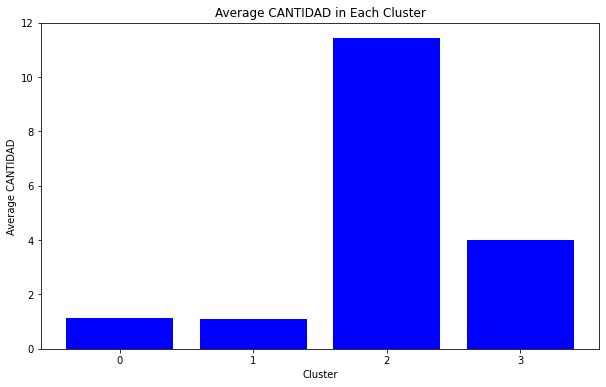

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

cluster_avg_cantidad = clustered_data.groupBy("cluster").agg({"CANTIDAD": "mean"})

cluster_avg_cantidad_df = cluster_avg_cantidad.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(cluster_avg_cantidad_df['cluster'], cluster_avg_cantidad_df['avg(CANTIDAD)'], color='blue')
plt.xlabel('Cluster')
plt.ylabel('Average CANTIDAD')
plt.title('Average CANTIDAD in Each Cluster')

plt.xticks(cluster_avg_cantidad_df['cluster'])
plt.show()

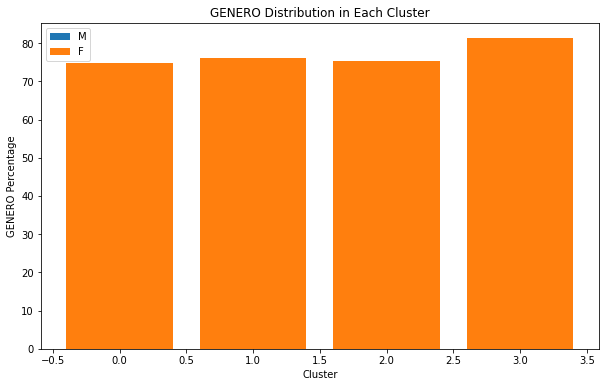

In [18]:
import matplotlib.pyplot as plt
import pandas as pd


cluster_gen_count = clustered_data.groupBy("cluster", "GENERO").count()
cluster_total = cluster_gen_count.groupBy("cluster").agg(F.sum("count").alias("total_count"))
cluster_gen_percent = cluster_gen_count.join(cluster_total, on="cluster")
cluster_gen_percent = cluster_gen_percent.withColumn("gen_percent", (F.col("count") / F.col("total_count")) * 100)
cluster_gen_percent_df = cluster_gen_percent.toPandas()
plt.figure(figsize=(10, 6))

for genero in cluster_gen_percent_df['GENERO'].unique():
    genero_data = cluster_gen_percent_df[cluster_gen_percent_df['GENERO'] == genero]
    plt.bar(genero_data['cluster'], genero_data['gen_percent'], label=genero)

plt.xlabel('Cluster')
plt.ylabel('GENERO Percentage')
plt.title('GENERO Distribution in Each Cluster')
plt.legend()

plt.show()


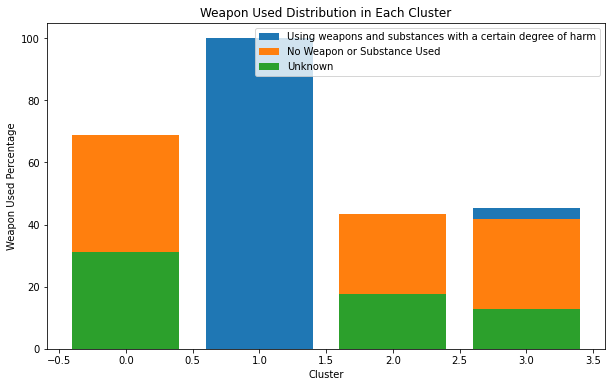

In [20]:
import matplotlib.pyplot as plt
import pandas as pd


cluster_weapon_count = clustered_data.groupBy("cluster", "Weapon Used").count()
cluster_total = cluster_weapon_count.groupBy("cluster").agg(F.sum("count").alias("total_count"))
cluster_weapon_percent = cluster_weapon_count.join(cluster_total, on="cluster")
cluster_weapon_percent = cluster_weapon_percent.withColumn("weapon_percent", (F.col("count") / F.col("total_count")) * 100)
cluster_weapon_percent_df = cluster_weapon_percent.toPandas()
plt.figure(figsize=(10, 6))
for weapon_used in cluster_weapon_percent_df['Weapon Used'].unique():
    weapon_used_data = cluster_weapon_percent_df[cluster_weapon_percent_df['Weapon Used'] == weapon_used]
    plt.bar(weapon_used_data['cluster'], weapon_used_data['weapon_percent'], label=weapon_used)

plt.xlabel('Cluster')
plt.ylabel('Weapon Used Percentage')
plt.title('Weapon Used Distribution in Each Cluster')
plt.legend()
plt.show()


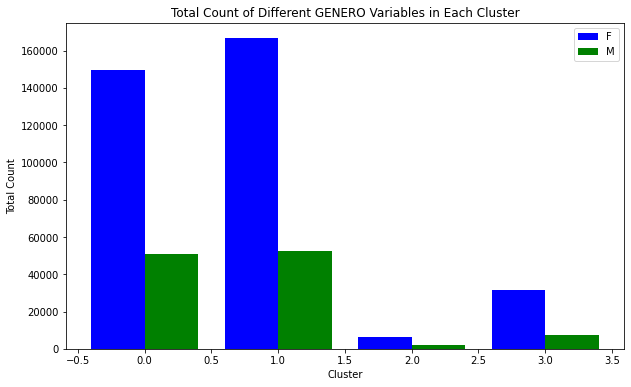

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

cluster_genero_count = clustered_data.groupBy("cluster", "GENERO").count()
cluster_genero_count_df = cluster_genero_count.toPandas()
plt.figure(figsize=(10, 6))
genero_categories = cluster_genero_count_df['GENERO'].unique()

colors = {'F': 'blue', 'M': 'green'}

for genero in genero_categories:
    genero_data = cluster_genero_count_df[cluster_genero_count_df['GENERO'] == genero]
    cluster_values = genero_data['cluster']
    counts = genero_data['count']
    plt.bar(cluster_values - 0.2 if genero == 'F' else cluster_values + 0.2, counts, width=0.4, label=genero, color=colors[genero])

plt.xlabel('Cluster')
plt.ylabel('Total Count')
plt.title('Total Count of Different GENERO Variables in Each Cluster')
plt.legend()
plt.show()
